#Dokumentforståelse med LayoutLMv3 på KVP10k-datasettet

Denne notebooken demonstrerer hvordan vi henter inn en preprossessert og tilpasset versjon av KVP10k-datasettet i Hugging Face-format, til å utføre **Key-Value Pair Extraction (KVP)** på  dokumentbilder.

- Datasettet består av over 10k forretningsdokumenter, og inneholder blant annet dokumentbilder og tilhørende nøkkel-verdi-par, som brukes av denne fine-tuned modellen som utvikles her.

- Sluttmålet er å utvikle og trene en ny modell til dokumentforståelse, ved å forstå **visuell layout**, **tekstlig innhold**, og **relasjoner mellom nøkler og verdier** i dokumentene.
  - KVP-Extraction modellen som utvikles i denne notebooken er tenkt å brukes grunnmur i sluttmodellen, for å med stor sannsynlighet beherske å linke mellom nøkkel-verdi-par i ulike dokumenter.

LayoutLMv3 er en multi-modal modell designet for å kombinere tekst, layout og annen bilde-informasjon

---

###**Notbooken dekker følgende steg**:

1. Installasjon av de nødendige biblioteker
2. Lasting av forhåndsprosessert datasett
3. Tokenisering av tekst og input-formatering med Layout sin Processor
- 3.1 Logikk for å anngi predikerte BIO-labels til dokumentets bbox'es
4. Trening av modell for token-klassifisering
5. Evaluering og lagring av modell i Drive
6. Visualisering av modell under inferense

---

###**LayoutLMv3Processor - gjør følgende**:
1. Tekst-tokenisering: Tekst fra dokumentet tokeniseres.
2. Token-connection: Hvert token kobles til en bounding box (bbox) på dokumentet, gjennom *boxes*-parmeteret som inneholder (x0,y0,x1,y1)-kordinater til hvert token.
3. Image-embedding: Dokumentbildet skaleres og legges og blir input til modellen
4. Label-alignment: Hvert token får en BIO-label, som brukes under modellens token-klassifisering

Tokeniseringen handler om å forvandle dokumentet til tokens med alle nødvendige modaliteter (tekst, layout og bilde) slik at modellen lærer sammenhengen mellom dem gjennom trening.

**Det brukes BIO-tagger, og dette er hva det står for:**
 - B --> Begin: første token i en entitet.
 - I --> Inside: inne i en entitet.
 - O --> Outside: tokenen er ikke en del av noen entitet

f.eks.
  - Tokens:  ["Name", "of", "buyer", ":", "Ole", "Martin", "Lystadmoen"]
  - Labels:  ["B-KEY", "I-KEY", "I-KEY", "O", "B-VALUE", "I-VALUE", "I-VALUE"]

In [12]:
import os
os.environ["WANDB_MODE"]="disabled"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"


# Dataset - forståelse

**Innhold i train/-mappen i KVP10k:**
_____
  - *images*/ --> .png bilder av hvert dokument. Visuell input for modellen.
    - Det modellen "ser".
_____

  - *ocrs*/ --> JSON-filer med **words** og **bboxes** for hvert dokument. Gir tekst og posisjoner fra OCR, og brukes sammen med images.
    - Det modellen "leser" (tokens og posisjonene deres).

_____

  - *gts*/ --> JSON-filer med KVPs og tilhørende bboxes. Inneholder hvilke keys og values som hører sammen.
    - Det som lærer modellen hvilke tokens som er nøkler, verdier, og hvilket som er koblet sammen.
_____

  - *items*/ --> JSON-filer med annotasjoner og layout-objs (rektangler, linker, etiketter)
    - tilleggsinformasjon
    - ikke viktig i for EE
    - Helt nødvendig i RE-delen av dette prosjektet
_____

In [48]:
TRAIN_MODEL=True

In [13]:
#transformers: Hugging Face bibliotek som gir tilgang til LayoutLMv3
#datasets: For håndtering av dataset i Huggig Face-format
#seqeval: evalueringsbibliotek for sekvensmerking, brukes for måle metrikker for i dette tilfelle BIO-tagging
!pip install -q -U transformers datasets seqeval

In [14]:
#Håndterer ulike metrikker inkl. integrasjon med seqeval
!pip install -q evaluate

In [15]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer
from transformers import LayoutLMv3Processor
import torch           #modellens input-format for data
from google.colab import drive

In [16]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
from evaluate import load
metric=load("seqeval")

In [18]:
base_path="/content/drive/MyDrive/KVP10k-dataset/kvp10k/"
print(os.listdir(base_path))

['train', 'test']


In [19]:
processor=LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map={
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps=[]
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps=sorted(overlaps)

  labeled=[]
  for j, idx in enumerate(overlaps):
    tag=f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


#Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0=max(box1[0], box2[0])
  y0=max(box1[1], box2[1])
  x1=min(box1[2], box2[2])
  y1=min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word+bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels=["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox=kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx]=tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box=kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx]=tag

  return labels

In [21]:
!ls -lh /content/drive/MyDrive/KVP10k_processed_ready

ls: /content/drive/MyDrive/KVP10k_processed_ready: No such file or directory
lrw------- 1 root root 0 Apr 21 09:10 /content/drive/MyDrive/KVP10k_processed_ready -> /content/drive/.shortcut-targets-by-id/1NbM9cwuCpZGK4W3yzn5hIDmqyp3uULqw/KVP10k_processed_ready


#Innlasting av et allerede pre-prossesert KVP10k-dataset spesielt utviklet for LayoutLMv3 (KVP-extraction).


Henter allerede preprosserert dataset for layout modellen og legger til entiteter og labels for relasjonslaget

In [22]:
from google.colab import drive
from datasets import load_from_disk

# Monter Drive (hvis du ikke har gjort det)
drive.mount("/content/drive", force_remount=True)

# Last inn dataset fra riktig path
dataset=load_from_disk("/content/drive/MyDrive/KVP10k_processed_ready/dataset_all_gts")

# Hent splits
train_dataset=dataset["train"]
eval_dataset=dataset["eval"]
test_dataset=dataset["test"]

Mounted at /content/drive


In [23]:
import random

def add_entity_pairs_and_labels(example, neg_per_pos: int=3):
    # Hent ut token-labels
    labels=example["labels"]
    id2label={0: "O", 1: "B-KEY", 2: "I-KEY", 3: "B-VALUE", 4: "I-VALUE"}

    # Finn KEY- og VALUE-spans
    key_spans, value_spans=[], []
    cur_span, cur_type=[], None
    for i, lab in enumerate(labels):
        if lab == -100:
            continue
        lbl=id2label[int(lab)]
        if lbl.startswith("B-"):
            # lagre forrige span
            if cur_span:
                (key_spans if cur_type=="KEY" else value_spans).append(cur_span)
            cur_span=[i]
            cur_type=lbl.split("-",1)[1]
        elif lbl.startswith("I-") and cur_type and lbl.endswith(cur_type):
            cur_span.append(i)
        else:
            if cur_span:
                (key_spans if cur_type=="KEY" else value_spans).append(cur_span)
            cur_span, cur_type=[], None
    if cur_span:
        (key_spans if cur_type=="KEY" else value_spans).append(cur_span)

    # Lag positive par
    pos_pairs=[(k, v) for k, v in zip(key_spans, value_spans)]
    pos_labels=[1.0] * len(pos_pairs)

    # Lag negative par
    neg_pairs, neg_labels=[], []
    if key_spans and value_spans:
        for k in key_spans:
            # kandidater som ikke er ekte par
            cands=[v for v in value_spans if (k,v) not in pos_pairs]
            for v in random.sample(cands, min(len(cands), neg_per_pos)):
                neg_pairs.append((k, v))
                neg_labels.append(0.0)

    # Fallback om ingen par
    if not pos_pairs:
        pos_pairs, pos_labels=[([0],[1])], [0.0]

    # Kombiner og tilordne
    example["entity_pairs"]=pos_pairs+neg_pairs
    example["rel_labels"]=pos_labels+neg_labels
    return example

# Apply to your datasets:
train_dataset=train_dataset.map(lambda ex: add_entity_pairs_and_labels(ex, neg_per_pos=3))
eval_dataset=eval_dataset.map(lambda ex: add_entity_pairs_and_labels(ex, neg_per_pos=1))
test_dataset=test_dataset.map(lambda ex: add_entity_pairs_and_labels(ex, neg_per_pos=1))

# And then:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")
test_dataset.set_format("torch")


# Sjekk at alt fungerer
print("Train:", len(train_dataset))
print("Eval:", len(eval_dataset))
print("Test:", len(test_dataset))
print("Keys:", train_dataset[0].keys())

Map:   0%|          | 0/6273 [00:00<?, ? examples/s]

Map:   0%|          | 0/1569 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Train: 6273
Eval: 1569
Test: 828
Keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'entity_pairs', 'rel_labels'])


In [24]:
train_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'entity_pairs': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'rel_labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [25]:
example=train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
entity_pairs torch.Size([1, 2, 1])
rel_labels torch.Size([1])


In [26]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'<s> Date Net Zone/Syscode Time Spot Name Len Line Rate Flag 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 4:44PM CLFTVNJO702H 30 48 $73.00 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 7:45PM CLFTVNJO702H 30 487 $90.00 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 11:46PM CLFTVNJO702H 30 487 $90.00 10-722 AEN Morris County Zone 1305/1305 2:13PM CLFTVNJO702H 30 488 $21.00 10-722 AEN Morris County Zone 1305/1305 5:40PM CLFTVNJO702H 30 489 $49.00 10-722 AEN Morris County Zone 1305/1305 7:44PM CLFTVNJO702H 30 490 $59.00 10-722 AEN Morris County Zone 1305/1305 10:48PM CLFTVNJO702H 30 490 $59.00 10-722 CNN Morris County Zone 1305/1305 8:29AM CLFTVNJO702H 30 491 $73.00 10-722 CNN Morris County Zone 1305/1305 3:30PM CLFTVNJO702H 30 492 $65.00 10-722 CNN Morris County Zone 1305/1305 4:26PM CLFTVNJO702H 30 493 $121.00 10-722 CNN Morris County Zone 1305/1305 9:27PM CLFTVNJO702H 30 494 $164.00 10-722 DISC Morris County Zone 1305/1305 9:25AM CLFTVNJO702H 30 495 $21.00 10-722 DISC Morris Coun

In [27]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 Date 0
 Net 0
 Zone 0
/ -100
Sys -100
code -100
 Time 0
 Spot 0
 Name 0
 Len 0
 Line 0
 Rate 0
 Flag 0
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 4 0
: -100
44 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
 $ 0
73 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 7 0
: -100
45 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
7 -100
 $ 0
90 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 11 0
: -100
46 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
7 -100
 $ 0
90 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 A 0
EN -100
 Morris 0
 County 0
 Zone 0
 130 0
5 -1

In [28]:
def collate_fn(batch):
    out={}
    # Stack standard tensors
    for k in ("input_ids", "bbox", "attention_mask", "labels", "image"):
        if k in batch[0]:
            out[k]=torch.stack([b[k] for b in batch])

    # Pad and stack rel_labels
    max_rel=max(len(b["rel_labels"]) for b in batch)
    rels=[]
    for b in batch:
        lab=b["rel_labels"]
        lab=lab.tolist() if isinstance(lab, torch.Tensor) else lab
        pad=lab+[0.0] * (max_rel - len(lab))
        rels.append(torch.tensor(pad, dtype=torch.float))
    out["rel_labels"]=torch.stack(rels)

    # Collect entity_pairs directly
    out["entity_pairs"]=[b["entity_pairs"] for b in batch]
    return out

In [29]:
import torch
from torch.utils.data import DataLoader


# DataLoaders
train_loader=DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
eval_loader=DataLoader(eval_dataset,  batch_size=8, shuffle=False, collate_fn=collate_fn)

In [30]:
label_list=["O", "B-KEY", "I-KEY", "B-VALUE", "I-VALUE"]
label2id={label: i for i, label in enumerate(label_list)}
id2label={i: label for i, label in enumerate(label_list)}

#Oppsett av Utvidet Layoutmvl3 model med et relasjons lag
Vi setter opp en base model som med et binært relasjonslag

##Setter opp metode for rekne ut metrikker for treningen

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(p):
    predictions, labels=p

    # === Token classification metrics (BIO tagging) – unchanged
    token_preds=predictions["token_logits"]
    token_labels=labels["labels"]

    token_preds=np.argmax(token_preds, axis=2)
    true_preds=[
        [id2label[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(token_preds, token_labels)
    ]
    true_labels=[
        [id2label[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(token_preds, token_labels)
    ]

    bio_result=metric.compute(predictions=true_preds, references=true_labels)

    # === Relation classification metrics (per‐pair binary) ===
    rel_logits=predictions["rel_logits"]    # shape (batch_size, max_pairs)
    rel_labels=labels["rel_labels"]         # same shape

    if rel_logits is not None and rel_labels is not None:
        # sigmoid → threshold → flatten
        rel_probs=1 / (1+np.exp(-rel_logits))
        rel_preds_bin=(rel_probs >= 0.5).astype(int).ravel()
        rel_labels_flat=np.array(rel_labels, dtype=int).ravel()

        rel_acc=accuracy_score(rel_labels_flat, rel_preds_bin)
        rel_f1=f1_score(rel_labels_flat, rel_preds_bin, average="macro")
        rel_precision=precision_score(rel_labels_flat, rel_preds_bin, average="macro")
        rel_recall=recall_score(rel_labels_flat, rel_preds_bin, average="macro")
    else:
        rel_acc=rel_f1=rel_precision=rel_recall=0.0

    return {
        # BIO tagging
        "precision": bio_result["overall_precision"],
        "recall":    bio_result["overall_recall"],
        "f1":        bio_result["overall_f1"],
        "accuracy":  bio_result["overall_accuracy"],

        # Relation prediction
        "rel_acc":       rel_acc,
        "rel_f1":        rel_f1,
        "rel_precision": rel_precision,
        "rel_recall":    rel_recall
    }

##Definerer modellen når

In [32]:
import torch
import torch.nn as nn
from transformers import LayoutLMv3Model


class RelationExtractionHead(nn.Module):
        super().__init__()

    def forward(self, h_i, h_j):
        head=self.head_proj(h_i)
        tail=self.tail_proj(h_j)
        logits=self.bilinear(head, tail)
        return logits

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import LayoutLMv3Model

class LayoutWithRelationModel(nn.Module):
    """
    LayoutLMv3-basert modell som bruker token-probabiliteter
    (token_probs) sammen med span-hidden-states for relasjonsklassifisering.
    """
    def __init__(
        self,
        model_name: str="microsoft/layoutlmv3-base",
        num_labels: int=5  # antall BIO-klasser
    ):
        super().__init__()
        # Grunnmodell
        self.layout=LayoutLMv3Model.from_pretrained(model_name)
        self.dropout=nn.Dropout(0.1)

        # Token-klassifisering (BIO)

        # Relasjonslag: h_i, h_j, h_mul, h_diff, h_dot, p_i, p_j
        self.rel_fc=nn.Sequential(
            nn.ReLU(),
        )

    def forward(
        self,
        input_ids,
        bbox,
        pixel_values=None,
        attention_mask=None,
        labels=None,
        entity_pairs=None,
        rel_labels=None
    ):
        # 1) LayoutLMv3 encoding
        outputs=self.layout(
            input_ids=input_ids,
            bbox=bbox,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            return_dict=True
        )
        hidden_states=self.dropout(outputs.last_hidden_state)  # (B, seq_len, H)

        # 2) Token-klassifisering
        token_logits=self.token_classifier(hidden_states)    # (B, seq_len, L)
        token_loss=None
        if labels is not None:
            token_loss=nn.CrossEntropyLoss()(  # BIO-tap
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )
        # Probabiliteter for hver token og klasse
        token_probs=F.softmax(token_logits, dim=-1)
        token_preds=token_logits.argmax(dim=-1)

        # 3) Relasjonsklassifisering
        rel_logits, rel_preds, rel_loss=None, None, None
        if entity_pairs is not None:
            batch_scores=[]
            for b_idx, pairs in enumerate(entity_pairs):
                h_b=hidden_states[b_idx]  # (seq_len, H)
                probs_b=token_probs[b_idx]    # (seq_len, L)
                scores=[]
                for hi_idxs, ti_idxs in pairs:
                    # Mean hidden for spans
                    h_i=h_b[hi_idxs].mean(dim=0)
                    h_j=h_b[ti_idxs].mean(dim=0)
                    # Span-interaksjoner
                    h_mul=h_i * h_j
                    h_diff=h_i - h_j
                    h_dot=torch.sum(h_i * h_j, dim=0, keepdim=True)
                    # Mean token-prob for spans
                    p_i=probs_b[hi_idxs].mean(dim=0)
                    p_j=probs_b[ti_idxs].mean(dim=0)
                    # Samle feature-vektor
                    feats=torch.cat([h_i, h_j, h_mul, h_diff, h_dot, p_i, p_j], dim=0)
                    scores.append(self.rel_fc(feats).squeeze())
                batch_scores.append(torch.stack(scores))

            # Pad for lik lengde
            max_pairs=max(s.size(0) for s in batch_scores)
            padded=[]
            for s in batch_scores:
                if s.size(0) < max_pairs:
                    pad=s.new_zeros(max_pairs - s.size(0))
                    s=torch.cat([s, pad], dim=0)
                padded.append(s)
            rel_logits=torch.stack(padded)            # (B, max_pairs)
            rel_preds=(torch.sigmoid(rel_logits) >= 0.5).long()
            if rel_labels is not None:
                rel_loss=nn.BCEWithLogitsLoss()(rel_logits, rel_labels.float())

        # 4) Kombiner tap
        loss=None
        if token_loss is not None and rel_loss is not None:
            loss=token_loss+0.5 * rel_loss
        else:
            loss=token_loss if token_loss is not None else rel_loss

        return {
            "loss":          loss,
            "token_logits":  token_logits,
            "token_preds":   token_preds,
            "rel_logits":    rel_logits,
            "rel_preds":     rel_preds,
            "hidden_states": hidden_states
        }

#Trainer oppsett
Inneholder:
  - Modellen (LayoutLMv3ForTokenClassification)
  - Args (hyperparametre som: epochs, batch_size, lr, lr_scheduler,    regularisering, eval_steps, metrics)
  - Datasetsplit (train, eval)
  - Tokenizer (from processor)
  - Collator (litt usikker på denne)
  - Metrikker for modellen


In [45]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

# === Freeze backbone if token-only training is needed (optional)
def freeze_backbone(model):
    for param in model.layout.parameters():
        param.requires_grad=False

# === Full training loop

def train_full_model(model, train_loader, eval_loader, optimizer, epochs=5, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.to(device)
    model.device=device  # <--- Ensure the model has a .device attribute

    for epoch in range(1, epochs+1):
        model.train()
        total_loss=0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
            optimizer.zero_grad()

            inputs={
                "input_ids": batch["input_ids"].to(device),
                "bbox": batch["bbox"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
                "pixel_values": batch.get("image", None).to(device) if "image" in batch and batch["image"] is not None else None,
                "entity_pairs": batch.get("entity_pairs"),
                "rel_labels": batch.get("rel_labels").to(device) if batch.get("rel_labels") is not None else None
            }
            output=model(**inputs)
            loss=output["loss"]
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()

        avg_loss=total_loss / len(train_loader)
        print(f"Epoch {epoch} - Avg Train Loss: {avg_loss:.4f}")

        # === Evaluation
        model.eval()
        all_token_preds, all_token_labels=[], []
        all_rel_preds, all_rel_labels=[], []

        with torch.no_grad():
            for batch in tqdm(eval_loader, desc=f"Epoch {epoch} Eval"):
                inputs={
                    "input_ids": batch["input_ids"].to(device),
                    "bbox": batch["bbox"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device),
                    "pixel_values": batch.get("image", None).to(device) if "image" in batch and batch["image"] is not None else None,
                    "entity_pairs": batch.get("entity_pairs"),
                    "rel_labels": batch.get("rel_labels").to(device) if batch.get("rel_labels") is not None else None
                }
                output=model(**inputs)

                # === Token metrics
                logits=output["token_logits"].argmax(-1).cpu()
                label_ids=inputs["labels"].cpu()
                for p_seq, l_seq in zip(logits, label_ids):
                    for p, l in zip(p_seq.tolist(), l_seq.tolist()):
                        if l != -100:
                            all_token_preds.append(p)
                            all_token_labels.append(l)

                # === Relation metrics (pairwise binary predictions)
                if output["rel_logits"] is not None and inputs["rel_labels"] is not None:
                    rel_logits=output["rel_logits"]
                    rel_labels=inputs["rel_labels"]

                    for pred_vec, label_vec in zip(torch.sigmoid(rel_logits), rel_labels):
                        pred_bin=(pred_vec >= 0.5).long()
                        all_rel_preds.extend(pred_bin.cpu().tolist())
                        all_rel_labels.extend(label_vec.long().cpu().tolist())

        # === Print token classification report
        print("\nToken Classification Report:")
        print(classification_report(all_token_labels, all_token_preds, target_names=list(id2label.values())))

        # === Print relation classification report (if available)
        if all_rel_preds:
            print("\nRelation Classification Report:")
            print(classification_report(all_rel_labels, all_rel_preds))

In [46]:
import torch
if TRAIN_MODEL:
  model=LayoutWithRelationModel(
      model_name="microsoft/layoutlmv3-base",
      num_labels=len(id2label)
  ).to(device)
  optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

  train_full_model(model, train_loader, eval_loader, optimizer, epochs=10, device=device)

Epoch 1 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 1 - Avg Train Loss: 0.7099


Epoch 1 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.93      0.96      0.94    198151
       B-KEY       0.90      0.83      0.86     14944
       I-KEY       0.79      0.75      0.77     17861
     B-VALUE       0.87      0.82      0.85     17309
     I-VALUE       0.89      0.77      0.83     32732

    accuracy                           0.91    280997
   macro avg       0.88      0.83      0.85    280997
weighted avg       0.91      0.91      0.91    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.25      0.35     58794
           1       0.06      0.25      0.10     12058

    accuracy                           0.25     70852
   macro avg       0.34      0.25      0.23     70852
weighted avg       0.52      0.25      0.31     70852



Epoch 2 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 2 - Avg Train Loss: 0.5549


Epoch 2 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.93      0.97      0.95    198151
       B-KEY       0.90      0.86      0.88     14944
       I-KEY       0.87      0.72      0.78     17861
     B-VALUE       0.88      0.83      0.85     17309
     I-VALUE       0.91      0.77      0.84     32732

    accuracy                           0.92    280997
   macro avg       0.90      0.83      0.86    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.24      0.35     58794
           1       0.10      0.40      0.16     12058

    accuracy                           0.27     70852
   macro avg       0.38      0.32      0.25     70852
weighted avg       0.57      0.27      0.32     70852



Epoch 3 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 3 - Avg Train Loss: 0.5173


Epoch 3 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.94      0.96      0.95    198151
       B-KEY       0.88      0.87      0.88     14944
       I-KEY       0.81      0.78      0.80     17861
     B-VALUE       0.87      0.85      0.86     17309
     I-VALUE       0.89      0.82      0.85     32732

    accuracy                           0.92    280997
   macro avg       0.88      0.86      0.87    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.24      0.36     58794
           1       0.11      0.45      0.17     12058

    accuracy                           0.28     70852
   macro avg       0.39      0.34      0.26     70852
weighted avg       0.58      0.28      0.32     70852



Epoch 4 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 4 - Avg Train Loss: 0.4788


Epoch 4 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.96      0.94      0.95    198151
       B-KEY       0.88      0.89      0.89     14944
       I-KEY       0.81      0.80      0.80     17861
     B-VALUE       0.83      0.90      0.86     17309
     I-VALUE       0.82      0.87      0.85     32732

    accuracy                           0.92    280997
   macro avg       0.86      0.88      0.87    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.24      0.35     58794
           1       0.12      0.51      0.20     12058

    accuracy                           0.28     70852
   macro avg       0.41      0.37      0.28     70852
weighted avg       0.60      0.28      0.33     70852



Epoch 5 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 5 - Avg Train Loss: 0.4526


Epoch 5 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.95      0.96      0.95    198151
       B-KEY       0.90      0.89      0.89     14944
       I-KEY       0.86      0.77      0.81     17861
     B-VALUE       0.86      0.88      0.87     17309
     I-VALUE       0.84      0.86      0.85     32732

    accuracy                           0.92    280997
   macro avg       0.88      0.87      0.88    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.23      0.35     58794
           1       0.14      0.62      0.23     12058

    accuracy                           0.30     70852
   macro avg       0.44      0.42      0.29     70852
weighted avg       0.64      0.30      0.33     70852



Epoch 6 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 6 - Avg Train Loss: 0.4307


Epoch 6 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.95      0.96      0.95    198151
       B-KEY       0.90      0.88      0.89     14944
       I-KEY       0.84      0.79      0.81     17861
     B-VALUE       0.87      0.88      0.87     17309
     I-VALUE       0.87      0.83      0.85     32732

    accuracy                           0.92    280997
   macro avg       0.88      0.87      0.88    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.24      0.36     58794
           1       0.12      0.51      0.20     12058

    accuracy                           0.29     70852
   macro avg       0.41      0.38      0.28     70852
weighted avg       0.61      0.29      0.33     70852



Epoch 7 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 7 - Avg Train Loss: 0.4109


Epoch 7 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.96      0.94      0.95    198151
       B-KEY       0.86      0.91      0.88     14944
       I-KEY       0.72      0.85      0.78     17861
     B-VALUE       0.84      0.89      0.87     17309
     I-VALUE       0.85      0.84      0.84     32732

    accuracy                           0.92    280997
   macro avg       0.85      0.88      0.86    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.23      0.36     58794
           1       0.14      0.62      0.23     12058

    accuracy                           0.30     70852
   macro avg       0.45      0.43      0.29     70852
weighted avg       0.65      0.30      0.33     70852



Epoch 8 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 8 - Avg Train Loss: 0.4023


Epoch 8 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.95      0.96      0.95    198151
       B-KEY       0.91      0.88      0.89     14944
       I-KEY       0.84      0.79      0.82     17861
     B-VALUE       0.89      0.86      0.87     17309
     I-VALUE       0.85      0.85      0.85     32732

    accuracy                           0.93    280997
   macro avg       0.89      0.87      0.88    280997
weighted avg       0.93      0.93      0.93    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.24      0.36     58794
           1       0.13      0.56      0.21     12058

    accuracy                           0.29     70852
   macro avg       0.43      0.40      0.29     70852
weighted avg       0.63      0.29      0.34     70852



Epoch 9 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 9 - Avg Train Loss: 0.3837


Epoch 9 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.96      0.95      0.95    198151
       B-KEY       0.87      0.91      0.89     14944
       I-KEY       0.81      0.83      0.82     17861
     B-VALUE       0.87      0.89      0.88     17309
     I-VALUE       0.85      0.85      0.85     32732

    accuracy                           0.92    280997
   macro avg       0.87      0.89      0.88    280997
weighted avg       0.93      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.23      0.36     58794
           1       0.15      0.65      0.24     12058

    accuracy                           0.30     70852
   macro avg       0.46      0.44      0.30     70852
weighted avg       0.66      0.30      0.34     70852



Epoch 10 Train:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 10 - Avg Train Loss: 0.3713


Epoch 10 Eval:   0%|          | 0/197 [00:00<?, ?it/s]


Token Classification Report:
              precision    recall  f1-score   support

           O       0.94      0.96      0.95    198151
       B-KEY       0.89      0.89      0.89     14944
       I-KEY       0.83      0.80      0.81     17861
     B-VALUE       0.89      0.85      0.87     17309
     I-VALUE       0.88      0.81      0.84     32732

    accuracy                           0.92    280997
   macro avg       0.89      0.86      0.87    280997
weighted avg       0.92      0.92      0.92    280997


Relation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.23      0.36     58794
           1       0.15      0.65      0.24     12058

    accuracy                           0.30     70852
   macro avg       0.45      0.44      0.30     70852
weighted avg       0.66      0.30      0.34     70852



In [49]:
import os
if TRAIN_MODEL:
  output_dir="/content/drive/MyDrive/KVP10k-layoutlmv3-v6"
  os.makedirs(output_dir, exist_ok=True)

  # Lagre modell
  torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
  processor.save_pretrained(output_dir)

  # Lagre prosessor
  processor.save_pretrained(output_dir)

#INFERENCE
Laster inn beste fine-tuned modell og dens tilhørende processor fra Drive, samt tilleggsinformasjon som kreves av processoren.



In [50]:
import torch
from transformers import AutoProcessor

model_path="/content/drive/MyDrive/KVP10k-layoutlmv3-v6"
num_labels=len(id2label)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor=AutoProcessor.from_pretrained(model_path, local_files_only=True)

model=LayoutWithRelationModel(
    model_name="microsoft/layoutlmv3-base",
    num_labels=num_labels
)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.to(device)
model.eval()

LayoutWithRelationModel(
  (layout): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder(
      (laye

#Kode prediksjon og visualisering av dette
###*Tokenisering og input-prosessering med Layout sin Processor ved inference*
Processor brukes her til å gjøre om tekst, bboxes, og bilde til format modell krever. Dette inkl:
- Tokenisering
- Normalisering av bboxes tilhørende hvert token
- Skalering av bilde
- Generering av input-tensorer

NB: Denne prosessen gjøres allerede i Data_Processor notebooken som ferdigstilte datasettet for **denne** notebooken. Selve prosessen er dermed nesten indentisk

In [51]:
#Nødvendig for å plassere boksene på originalt-format på bilde-dokumentet
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

#Velg vilkårlig dokument fra datasettet og prediker

In [52]:
# === Velg dokument
#document_selected="aaf643426f0250efd10de3d9df63b407292f3fcc2aa335e399c37aca32443ea1"
document_selected="aaed61e79aa3edbae844f5775789ebb6aa1a94a23d9cb3468d2cfc974af304e5"
# document_selected="aa35720ba3611f946c372cc99d8cd1d78e81265b8ceb51dcdb4672d196944c2b"
# document_selected="faa5d71172e2e9959b41a5aec4fd2ab700534d1b2729484d2d5f26472cd56cfa"
# document_selected="ffe462e43b9dff12e78ea8fb69332abfb789da171a8597f5bb961853e06e6fa2"
# document_selected="feb2c4b21388318c7a51cc0aaf0e7c673a07f5204a40549a281bef065bb77925"
# document_selected="feaf84d435bd46100db82de51f5a989ff4d39fdcdb040a7044720b943e34b7d7"
# document_selected="df6b0a4cf1908bb95be874e4efa59411c685095d7bb596879961563503b5c239"

In [57]:
from sklearn.metrics import classification_report

def evaluate_token_head(model, dataloader):
    model.eval()
    all_preds, all_labels=[], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids=batch["input_ids"].to(device)
            bbox=batch["bbox"].to(device)
            attention_mask=batch["attention_mask"].to(device)
            labels=batch["labels"].to(device)

            output=model(
                input_ids=input_ids,
                bbox=bbox,
                attention_mask=attention_mask,
                pixel_values=batch.get("image")
            )
            token_logits=output["token_logits"]
            preds=token_logits.argmax(-1)

            for p_seq, l_seq in zip(preds, labels):
                for p, l in zip(p_seq.cpu().tolist(), l_seq.cpu().tolist()):
                    if l != -100:
                        all_preds.append(p)
                        all_labels.append(l)

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values())))

In [58]:
evaluate_token_head(model, eval_loader)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


              precision    recall  f1-score   support

           O       0.94      0.96      0.95    198151
       B-KEY       0.89      0.89      0.89     14944
       I-KEY       0.83      0.80      0.81     17861
     B-VALUE       0.89      0.85      0.87     17309
     I-VALUE       0.88      0.81      0.84     32732

    accuracy                           0.92    280997
   macro avg       0.89      0.86      0.87    280997
weighted avg       0.92      0.92      0.92    280997



In [59]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def predict_tokens(doc_id, show_gt=True):
    device=next(model.parameters()).device
    model.eval()

    base_path="/content/drive/MyDrive/KVP10k-dataset/kvp10k/test"
    image_path=f"{base_path}/images/{doc_id}.png"
    ocr_path=f"{base_path}/ocrs/{doc_id}.json"
    gt_path=f"{base_path}/gts/{doc_id}.json"

    image=Image.open(image_path).convert("RGB")
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr_data=json.load(f)
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data=json.load(f)

    page=ocr_data["pages"][0]
    words=[w["text"] for w in page["words"]]
    raw_boxes=[w["bbox"] for w in page["words"]]
    width, height=page["width"], page["height"]
    norm_boxes=[normalize_bbox(b, width, height) for b in raw_boxes]

    string_labels=iob_from_kvps(words, raw_boxes, gt_data["kvps_list"])
    word_labels=[label_map.get(lbl, 0) for lbl in string_labels]

    encoding=processor(
        image,
        words,
        boxes=norm_boxes,
        word_labels=word_labels,
        return_tensors="pt",
        truncation=True,
        padding="max_length"
    )

    word_ids=encoding.word_ids()
    labels=[-100] * len(word_ids)
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        label_str=string_labels[word_idx]
        labels[idx]=label_map[label_str]
    encoding["labels"]=torch.tensor([labels])

    inputs={k: v.to(device) for k, v in encoding.items()}
    with torch.no_grad():
        outputs=model(
            input_ids=inputs["input_ids"],
            bbox=inputs["bbox"],
            pixel_values=inputs["pixel_values"],
            attention_mask=inputs["attention_mask"]
        )

    input_ids=inputs["input_ids"].squeeze().tolist()
    predictions=outputs["token_logits"].argmax(-1).squeeze().tolist()
    bboxes=inputs["bbox"].squeeze().tolist()
    unnorm_boxes=[unnormalize_box(b, width, height) for b in bboxes]
    tokens=[processor.tokenizer.decode([tid]) for tid in input_ids]

    filtered=[
        (token, id2label.get(pred, "O"), box)
        for token, pred, box in zip(tokens, predictions, unnorm_boxes)
        if token not in ["[PAD]", "[CLS]", "[SEP]"]
    ]

    print("Unike labels i output:", set(p[1] for p in filtered))

    draw=ImageDraw.Draw(image)
    font=ImageFont.load_default()

    def iob_to_label(label):
        return label[2:].lower() if label.startswith(("B-", "I-")) else "other"

    label2color={
        "key": "blue",
        "value": "green",
        "other": "gray"
    }

    for token, pred_label, box in filtered:
        if pred_label == "O":
            continue
        label_type=iob_to_label(pred_label)
        draw.rectangle(box, outline=label2color.get(label_type, "red"), width=2)
        draw.text((box[0]+5, box[1] - 10), label_type, fill=label2color.get(label_type, "red"), font=font)

    print("Modellens prediksjoner:")
    display(image)

    if show_gt:
        gt_img=Image.open(image_path).convert("RGB")
        draw_gt=ImageDraw.Draw(gt_img)
        for word, box, label_id in zip(words, raw_boxes, string_labels):
            if label_id == "O":
                continue
            label_type=iob_to_label(label_id)
            draw_gt.rectangle(box, outline=label2color.get(label_type, "gray"), width=2)
            draw_gt.text((box[0]+5, box[1] - 10), label_type, fill=label2color.get(label_type, "gray"), font=font)

        print("Ground Truth:")
        display(gt_img)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Unike labels i output: {'I-KEY', 'B-VALUE', 'O', 'I-VALUE', 'B-KEY'}
Modellens prediksjoner:


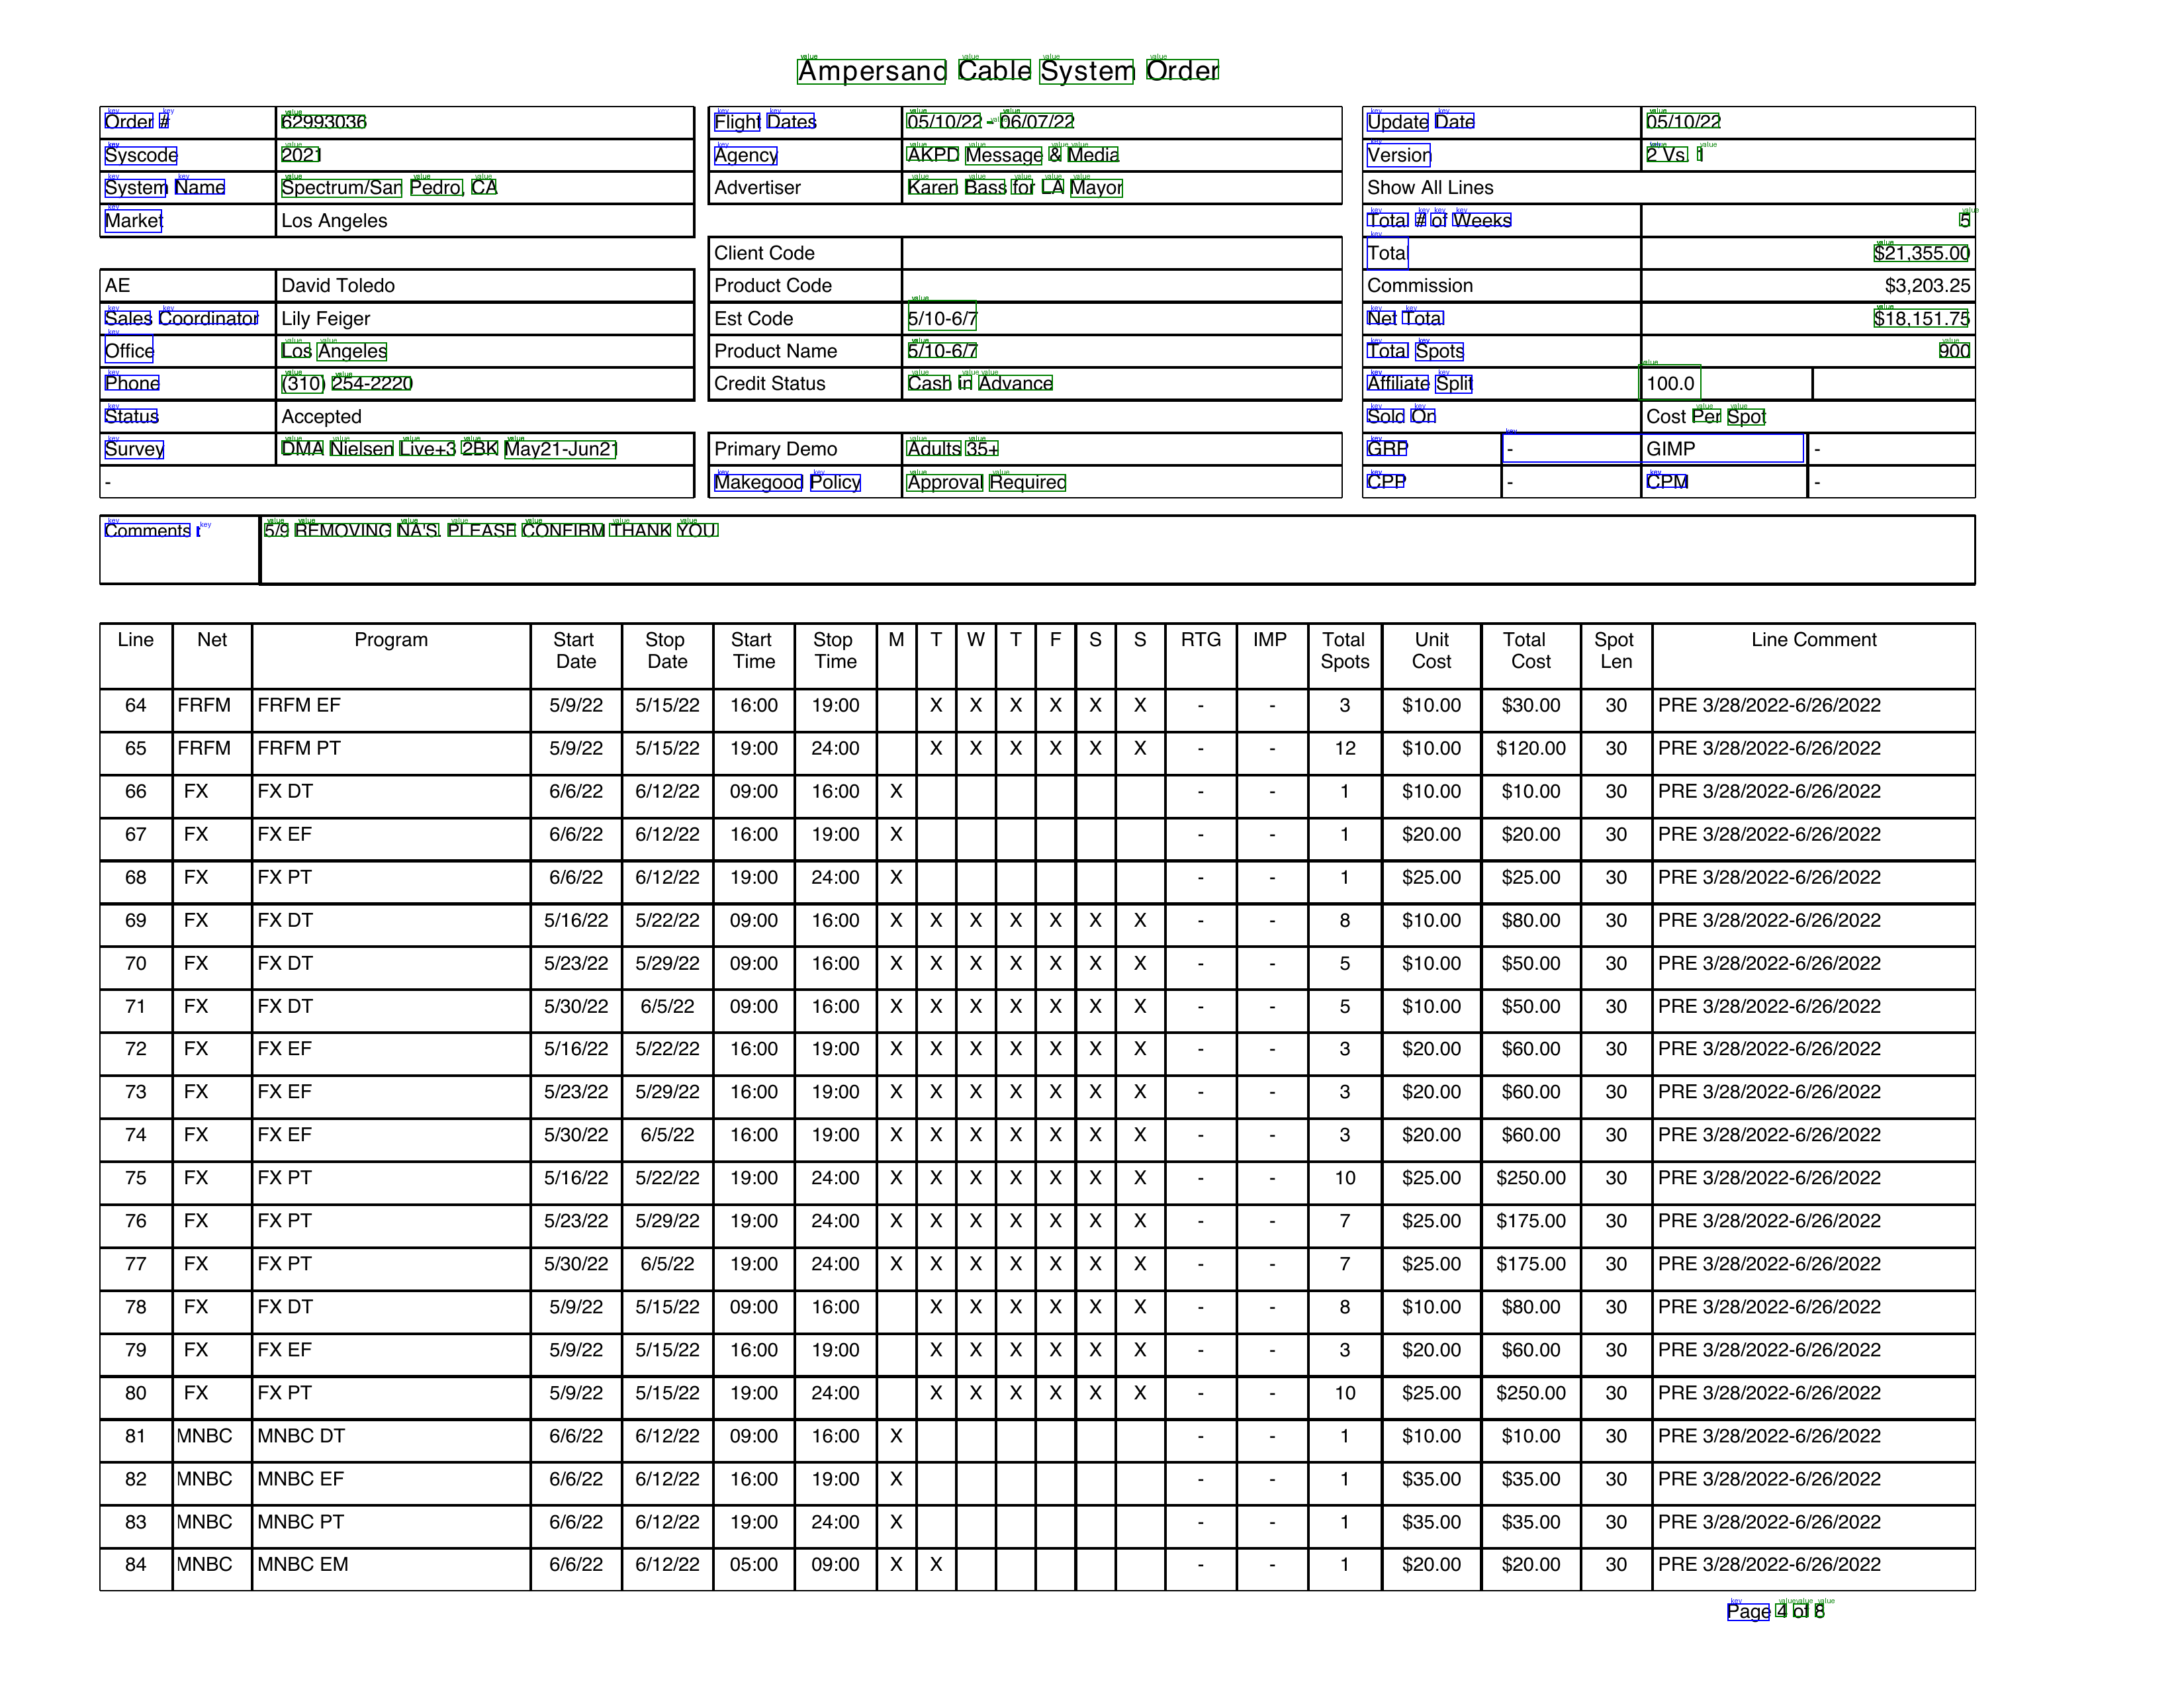

Ground Truth:


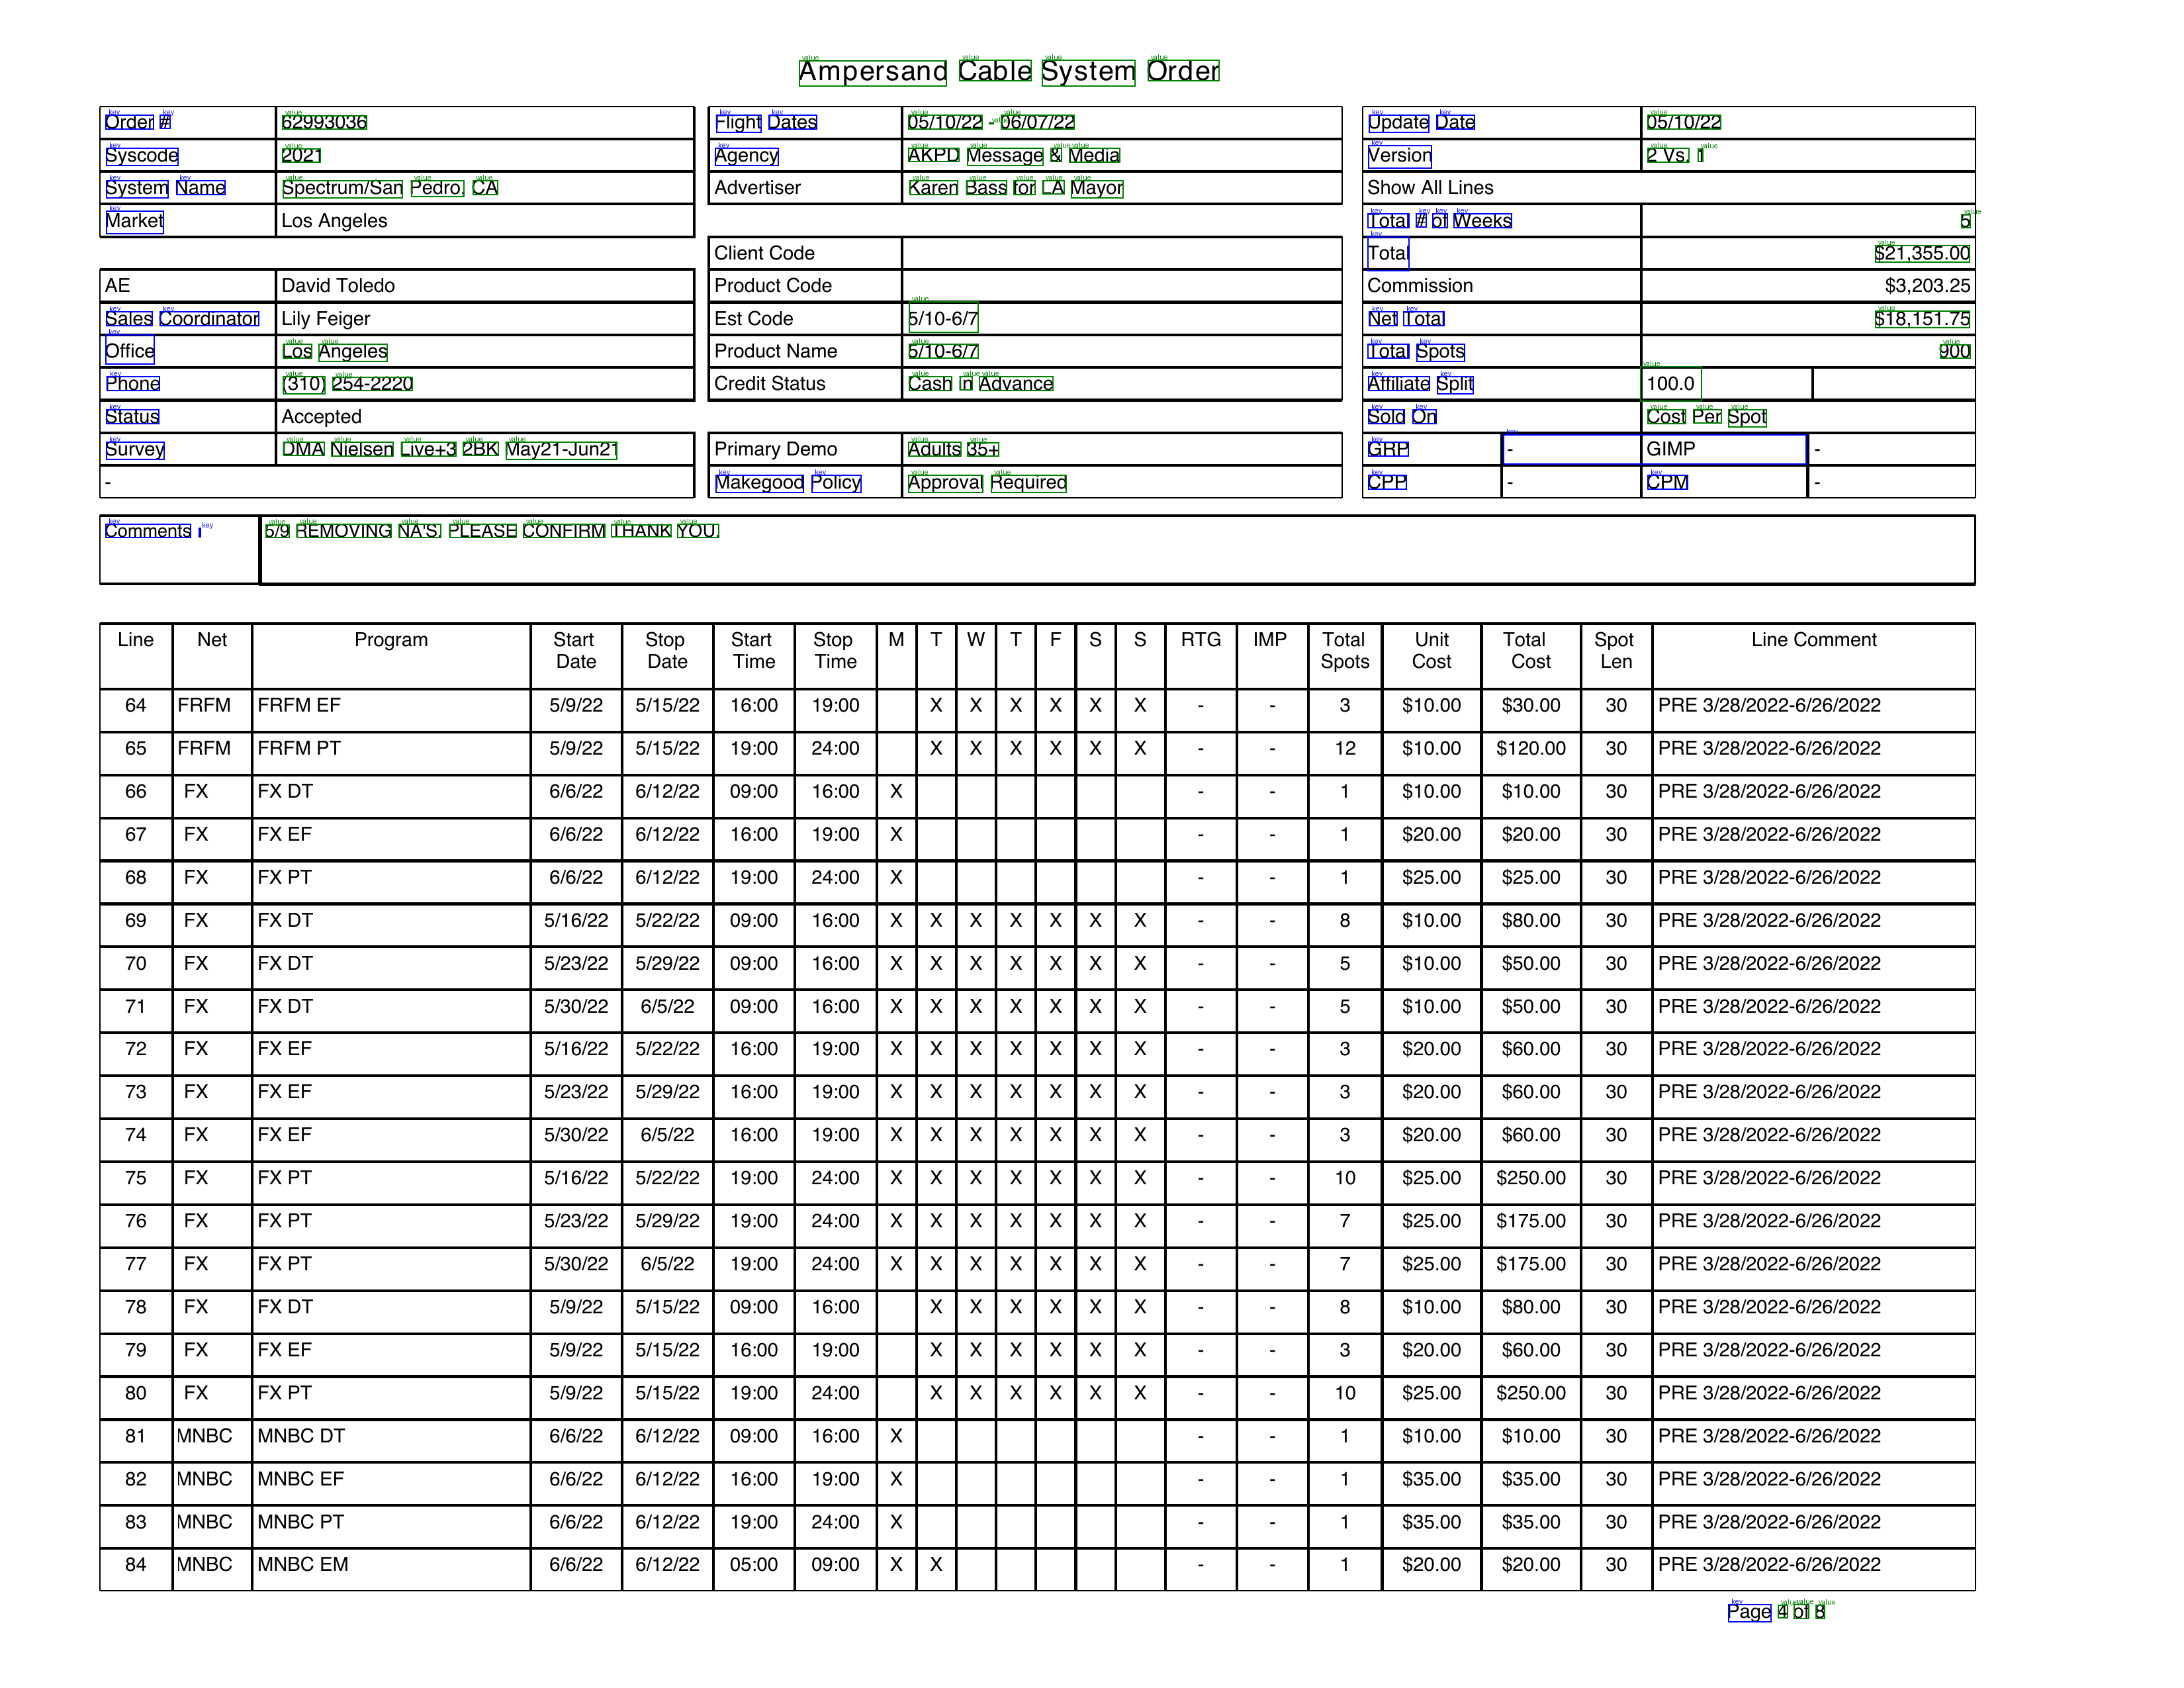

In [60]:
predict_tokens(document_selected)

In [94]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import json
import torch
import math
import os

def predict_relations(doc_id: str, threshold: float=0.6):
    # helper to extract BIO spans
    def extract_spans(labels, kind):
        spans, cur=[], []
        for idx, lab in enumerate(labels):
            if lab == f"B-{kind}":
                if cur:
                    spans.append(cur)
                cur=[idx]
            elif lab == f"I-{kind}" and cur:
                cur.append(idx)
            else:
                if cur:
                    spans.append(cur)
                cur=[]
        if cur:
            spans.append(cur)
        return spans

    # load image & OCR
    base="/content/drive/MyDrive/KVP10k-dataset/kvp10k/test"
    img_path=f"{base}/images/{doc_id}.png"
    ocr_path=f"{base}/ocrs/{doc_id}.json"
    image=Image.open(img_path).convert("RGB")
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr=json.load(f)

    page=ocr["pages"][0]
    words=[w["text"] for w in page["words"]]
    raw_boxes=[w["bbox"] for w in page["words"]]
    W, H=page["width"], page["height"]
    norm_boxes=[normalize_bbox(b, W, H) for b in raw_boxes]

    # get token labels and spans
    enc=processor(
        image, words, boxes=norm_boxes,
        return_tensors="pt", truncation=True, padding="max_length"
    )
    token_boxes=enc["bbox"][0].cpu().tolist()
    for k in ("input_ids", "bbox", "pixel_values", "attention_mask"):
        enc[k]=enc[k].to(device)

    model.eval()
    with torch.no_grad():
        out_tokens=model(
            input_ids=enc["input_ids"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
            attention_mask=enc["attention_mask"],
        )
    pred_ids=out_tokens["token_logits"][0].argmax(-1).tolist()
    labels_pred=[id2label.get(i, "O") for i in pred_ids]
    key_spans=extract_spans(labels_pred, "KEY")
    value_spans=extract_spans(labels_pred, "VALUE")

    # build entity_pairs
    pairs=[(k, v) for k in key_spans for v in value_spans]
    with torch.no_grad():
        out=model(
            input_ids=enc["input_ids"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
            attention_mask=enc["attention_mask"],
            entity_pairs=[pairs],
        )
    rel_logits=out["rel_logits"][0]

    relations=[]
    for idx, (k_span, v_span) in enumerate(pairs):
        prob=torch.sigmoid(rel_logits[idx]).item()
        if prob >= threshold:
            relations.append((k_span, v_span, prob))

    # draw results
    draw=ImageDraw.Draw(image)
    arrow_len=15
    arrow_ang=math.radians(25)

    # prøv å laste TTF, ellers default
    font_path="/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size=24
    if os.path.isfile(font_path):
        font=ImageFont.truetype(font_path, font_size)
    else:
        print(f"Warning: font not found at {font_path}, using default.")
        font=ImageFont.load_default(font_size)

    if not relations:
        draw.text((10, 10), "Ingen relasjoner funnet",
                  fill="orange", font=font)
    else:
        for k_span, v_span, prob in relations:
            # draw boxes
            for i in k_span:
                draw.rectangle(
                    unnormalize_box(token_boxes[i], W, H),
                    outline="blue", width=2
                )
            for i in v_span:
                draw.rectangle(
                    unnormalize_box(token_boxes[i], W, H),
                    outline="green", width=2
                )

            # compute arrow endpoints
            kxs=[(b[0]+b[2]) / 2
                   for idx in k_span
                   for b in [token_boxes[idx]]]
            kys=[(b[1]+b[3]) / 2
                   for idx in k_span
                   for b in [token_boxes[idx]]]
            vxs=[(b[0]+b[2]) / 2
                   for idx in v_span
                   for b in [token_boxes[idx]]]
            vys=[(b[1]+b[3]) / 2
                   for idx in v_span
                   for b in [token_boxes[idx]]]
            kc=((sum(kxs) / len(kxs)) * W / 1000,
                  (sum(kys) / len(kys)) * H / 1000)
            vc=((sum(vxs) / len(vxs)) * W / 1000,
                  (sum(vys) / len(vys)) * H / 1000)

            # draw arrow
            dx, dy=vc[0] - kc[0], vc[1] - kc[1]
            dist=math.hypot(dx, dy)
            if dist > arrow_len:
                ux, uy=dx / dist, dy / dist
                tail=kc
                head_base=(vc[0] - ux * arrow_len,
                             vc[1] - uy * arrow_len)
                draw.line([tail, head_base],
                          fill="red", width=2)
            else:
                head_base=kc

            # draw arrowhead
            ux, uy=((vc[0] - head_base[0]) / arrow_len,
                      (vc[1] - head_base[1]) / arrow_len)
            left_x=vc[0] - arrow_len * (
                ux * math.cos(arrow_ang)
+uy * math.sin(arrow_ang)
            )
            left_y=vc[1] - arrow_len * (
                uy * math.cos(arrow_ang)
                - ux * math.sin(arrow_ang)
            )
            right_x=vc[0] - arrow_len * (
                ux * math.cos(arrow_ang)
                - uy * math.sin(arrow_ang)
            )
            right_y=vc[1] - arrow_len * (
                uy * math.cos(arrow_ang)
+ux * math.sin(arrow_ang)
            )
            draw.polygon([vc, (left_x, left_y),
                          (right_x, right_y)],
                         fill="red")

            # draw percent label
            perc=f"{prob * 100:.1f}%"
            text_pos=(vc[0]+3, vc[1] - 30)
            draw.text(text_pos, perc,
                      fill="red", font=font)

    display(image)

In [95]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import json
import torch
import math
import os

def predict_relations_per_key(doc_id: str, threshold: float=0.6):
    # helper for å hente ut BIO-spans, kun der mask==1
    def extract_spans(labels, mask, kind):
        spans, cur=[], []
        for idx, (lab, m) in enumerate(zip(labels, mask)):
            if m == 0:  # pad-token ⇒ avslutt span
                if cur:
                    spans.append(cur)
                    cur=[]
                continue
            if lab == f"B-{kind}":
                if cur:
                    spans.append(cur)
                cur=[idx]
            elif lab == f"I-{kind}" and cur:
                cur.append(idx)
            else:
                if cur:
                    spans.append(cur)
                    cur=[]
        if cur:
            spans.append(cur)
        return spans

    # 1) load image+OCR
    base="/content/drive/MyDrive/KVP10k-dataset/kvp10k/test"
    img_path=f"{base}/images/{doc_id}.png"
    ocr_path=f"{base}/ocrs/{doc_id}.json"
    image=Image.open(img_path).convert("RGB")
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr=json.load(f)

    page=ocr["pages"][0]
    words=[w["text"] for w in page["words"]]
    raw_boxes=[w["bbox"] for w in page["words"]]
    W, H=page["width"], page["height"]
    norm_boxes=[normalize_bbox(b, W, H) for b in raw_boxes]

    # 2) token-klassifisering for spans
    enc=processor(
        image,
        words,
        boxes=norm_boxes,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
    )
    token_boxes=enc["bbox"][0].cpu().tolist()
    for k in ("input_ids", "bbox", "pixel_values", "attention_mask"):
        enc[k]=enc[k].to(device)

    model.eval()
    with torch.no_grad():
        out_tokens=model(
            input_ids=enc["input_ids"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
            attention_mask=enc["attention_mask"],
        )

    pred_ids=out_tokens["token_logits"][0].argmax(-1).tolist()
    mask=enc["attention_mask"][0].cpu().tolist()
    labels_pred=[id2label.get(i, "O") for i in pred_ids]

    key_spans=extract_spans(labels_pred, mask, "KEY")
    value_spans=extract_spans(labels_pred, mask, "VALUE")

    # 3) bygg (key,value)-par og hent rel_logits
    pairs=[(k, v) for k in key_spans for v in value_spans]
    with torch.no_grad():
        out=model(
            input_ids=enc["input_ids"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
            attention_mask=enc["attention_mask"],
            entity_pairs=[pairs],
        )
    rel_logits=out["rel_logits"][0]

    # 4) velg beste VALUE per KEY (over threshold)
    best_for_key={}
    for idx, (k_span, v_span) in enumerate(pairs):
        prob=torch.sigmoid(rel_logits[idx]).item()
        key_t=tuple(k_span)
        if key_t not in best_for_key or prob > best_for_key[key_t][2]:
            best_for_key[key_t]=(k_span, v_span, prob)

    relations=[
        (k, v, p) for (k, v, p) in best_for_key.values() if p >= threshold
    ]

    # 5) tegn ALLE spans+én pil per KEY→beste VALUE
    draw=ImageDraw.Draw(image)
    arrow_len=15
    arrow_angle=math.radians(25)

    # prøv å laste TTF, ellers default
    font_path="/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size=24
    if os.path.isfile(font_path):
        font=ImageFont.truetype(font_path, font_size)
    else:
        print(f"Warning: font not found at {font_path}, using default.")
        font=ImageFont.load_default(font_size)

    # tegn alle KEY i blått
    for k_span in key_spans:
        for i in k_span:
            draw.rectangle(
                unnormalize_box(token_boxes[i], W, H), outline="blue", width=2
            )

    # tegn alle VALUE i grønt
    for v_span in value_spans:
        for i in v_span:
            draw.rectangle(
                unnormalize_box(token_boxes[i], W, H), outline="green", width=2
            )

    if not relations:
        draw.text((10, 10), "Ingen relasjoner funnet", fill="orange", font=font)
    else:
        for k_span, v_span, prob in relations:
            # finn sentrumspunkt
            kxs=[(b[0]+b[2]) / 2 for idx in k_span for b in [token_boxes[idx]]]
            kys=[(b[1]+b[3]) / 2 for idx in k_span for b in [token_boxes[idx]]]
            vxs=[(b[0]+b[2]) / 2 for idx in v_span for b in [token_boxes[idx]]]
            vys=[(b[1]+b[3]) / 2 for idx in v_span for b in [token_boxes[idx]]]
            kc=((sum(kxs) / len(kxs)) * W / 1000, (sum(kys) / len(kys)) * H / 1000)
            vc=((sum(vxs) / len(vxs)) * W / 1000, (sum(vys) / len(vys)) * H / 1000)

            # tegn pil
            dx, dy=vc[0] - kc[0], vc[1] - kc[1]
            dist=math.hypot(dx, dy)
            if dist > arrow_len:
                ux, uy=dx / dist, dy / dist
                tail=kc
                head_base=(vc[0] - ux * arrow_len, vc[1] - uy * arrow_len)
                draw.line([tail, head_base], fill="red", width=2)
            else:
                head_base=kc

            # tegn pilhode
            ux, uy=(
                (vc[0] - head_base[0]) / arrow_len,
                (vc[1] - head_base[1]) / arrow_len,
            )
            left_x=vc[0] - arrow_len * (
                ux * math.cos(arrow_angle)+uy * math.sin(arrow_angle)
            )
            left_y=vc[1] - arrow_len * (
                uy * math.cos(arrow_angle) - ux * math.sin(arrow_angle)
            )
            right_x=vc[0] - arrow_len * (
                ux * math.cos(arrow_angle) - uy * math.sin(arrow_angle)
            )
            right_y=vc[1] - arrow_len * (
                uy * math.cos(arrow_angle)+ux * math.sin(arrow_angle)
            )
            draw.polygon([vc, (left_x, left_y), (right_x, right_y)], fill="red")

            # lesbar prosent-label for hver pil
            perc=f"{prob * 100:.1f}%"
            text_pos=(vc[0]+3, vc[1] - 30)
            draw.text(text_pos, perc, fill="red", font=font)

    display(image)

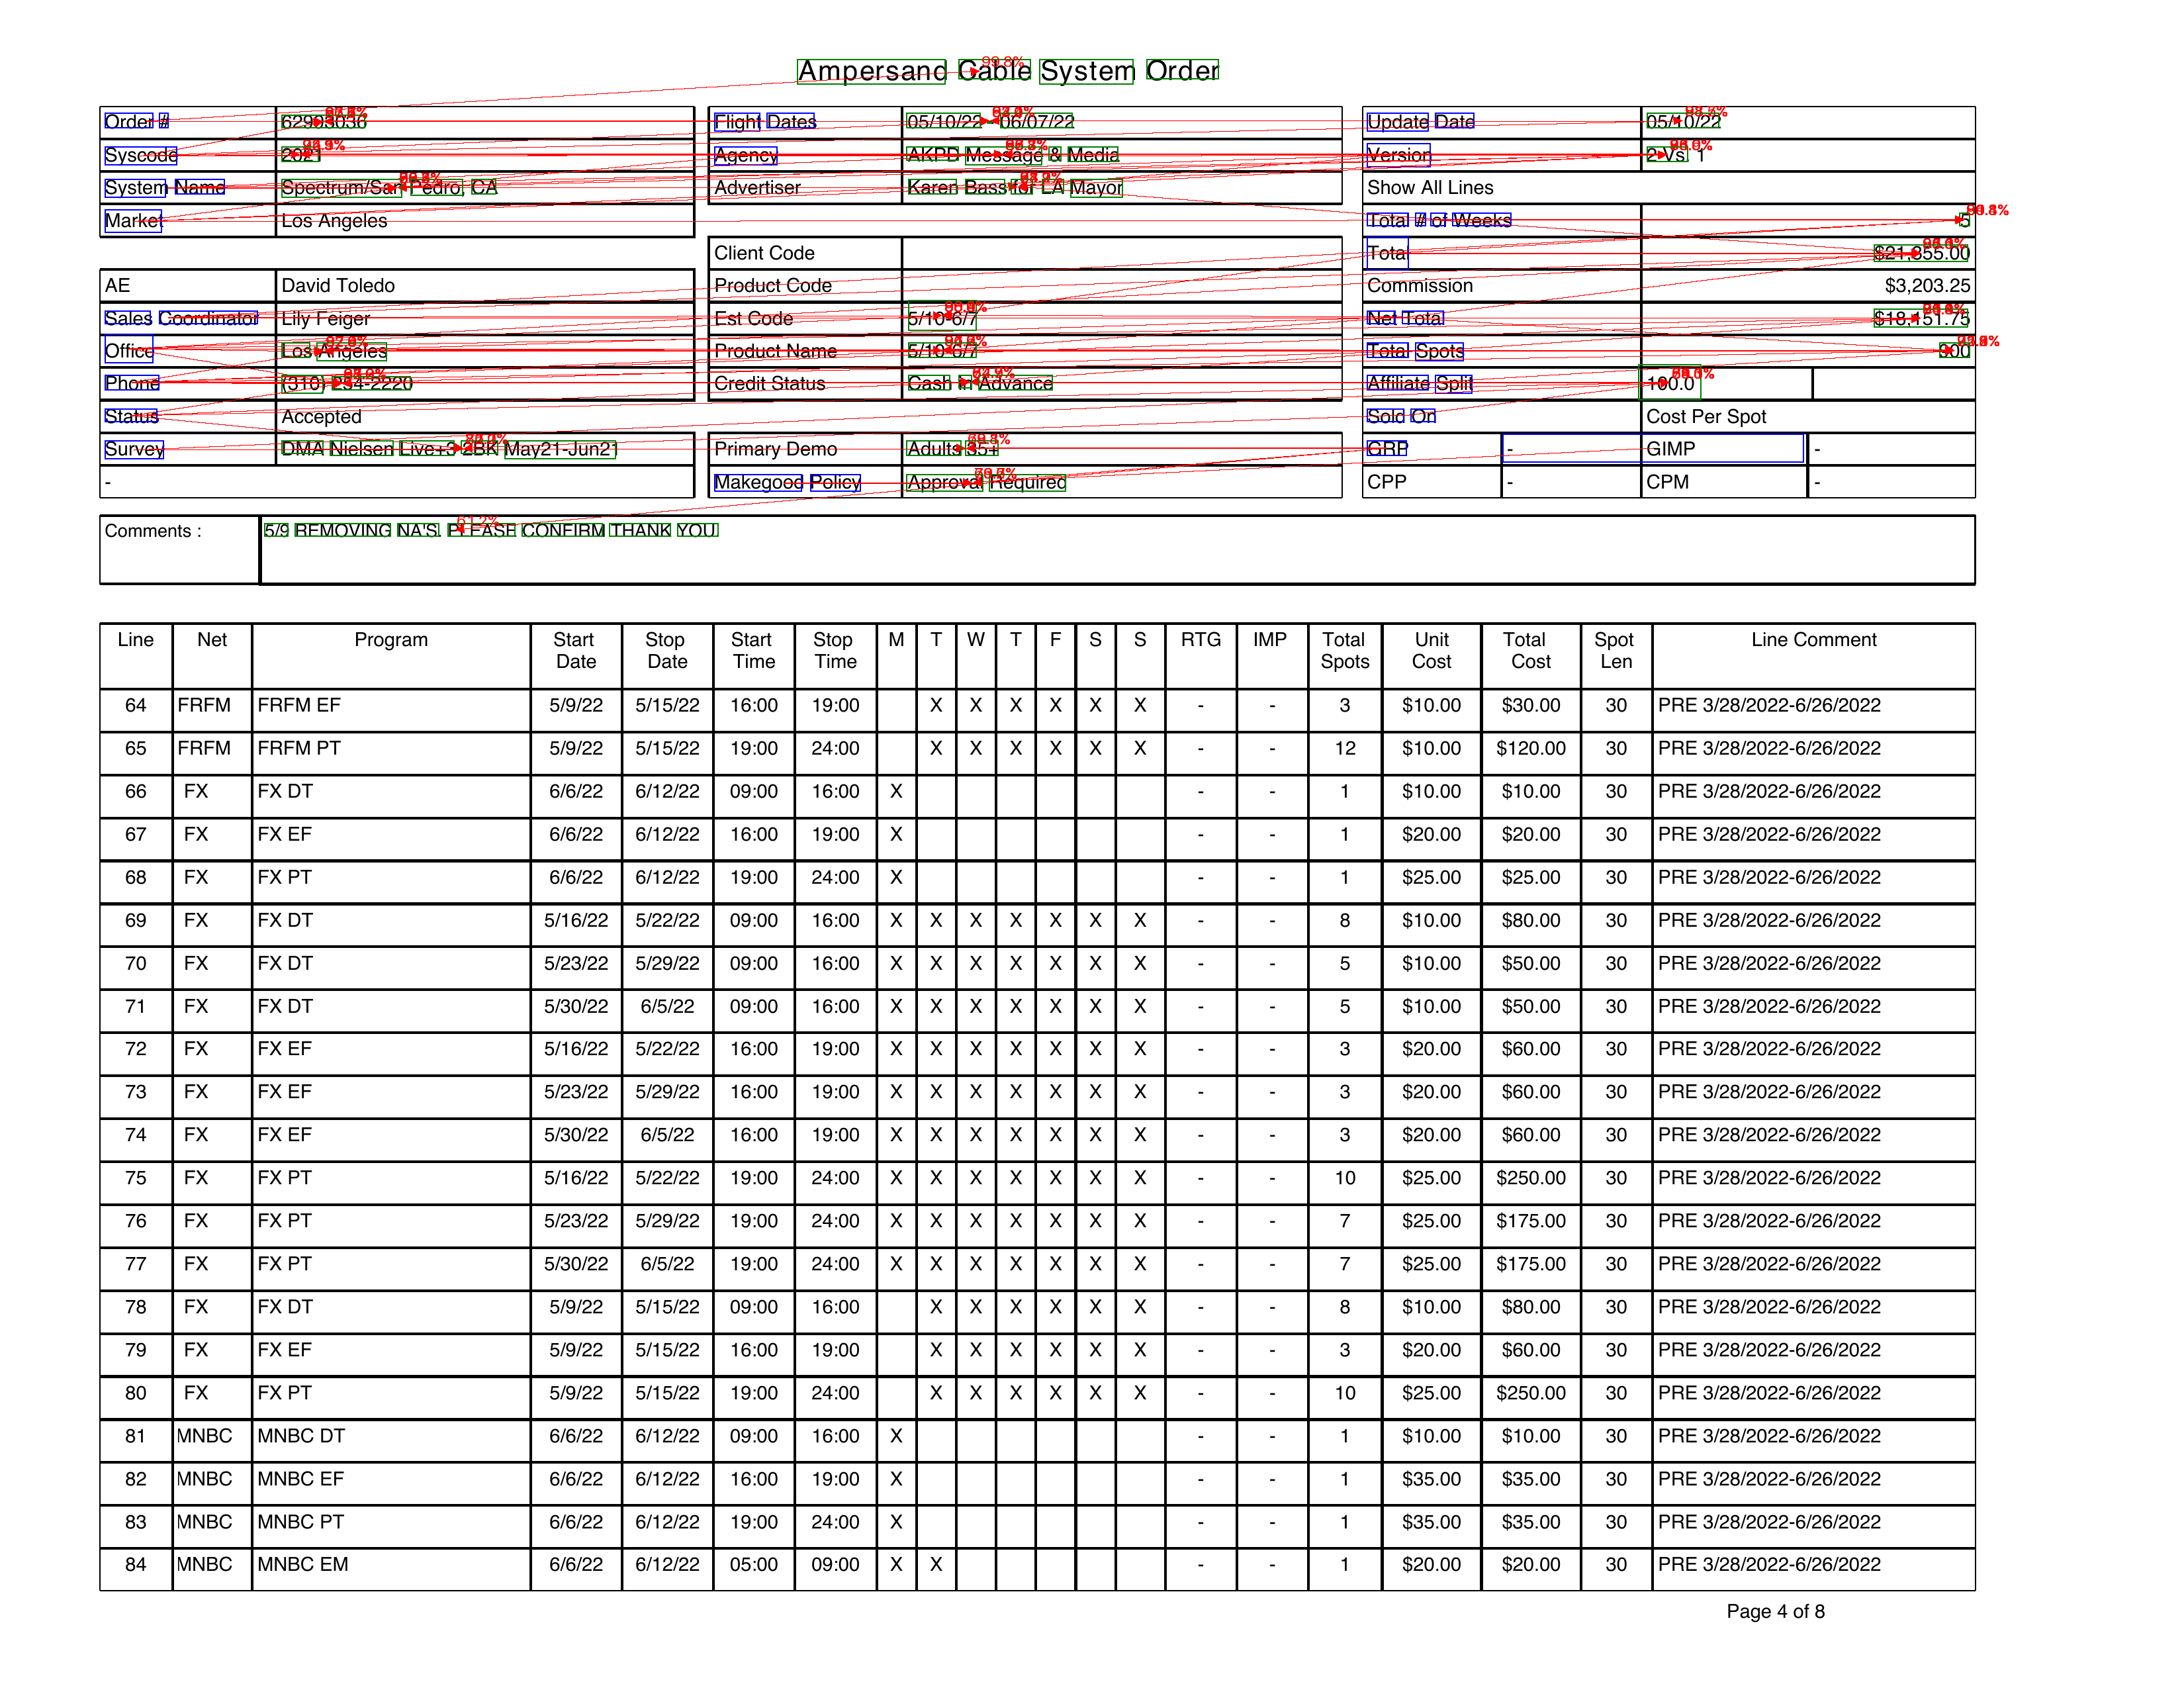

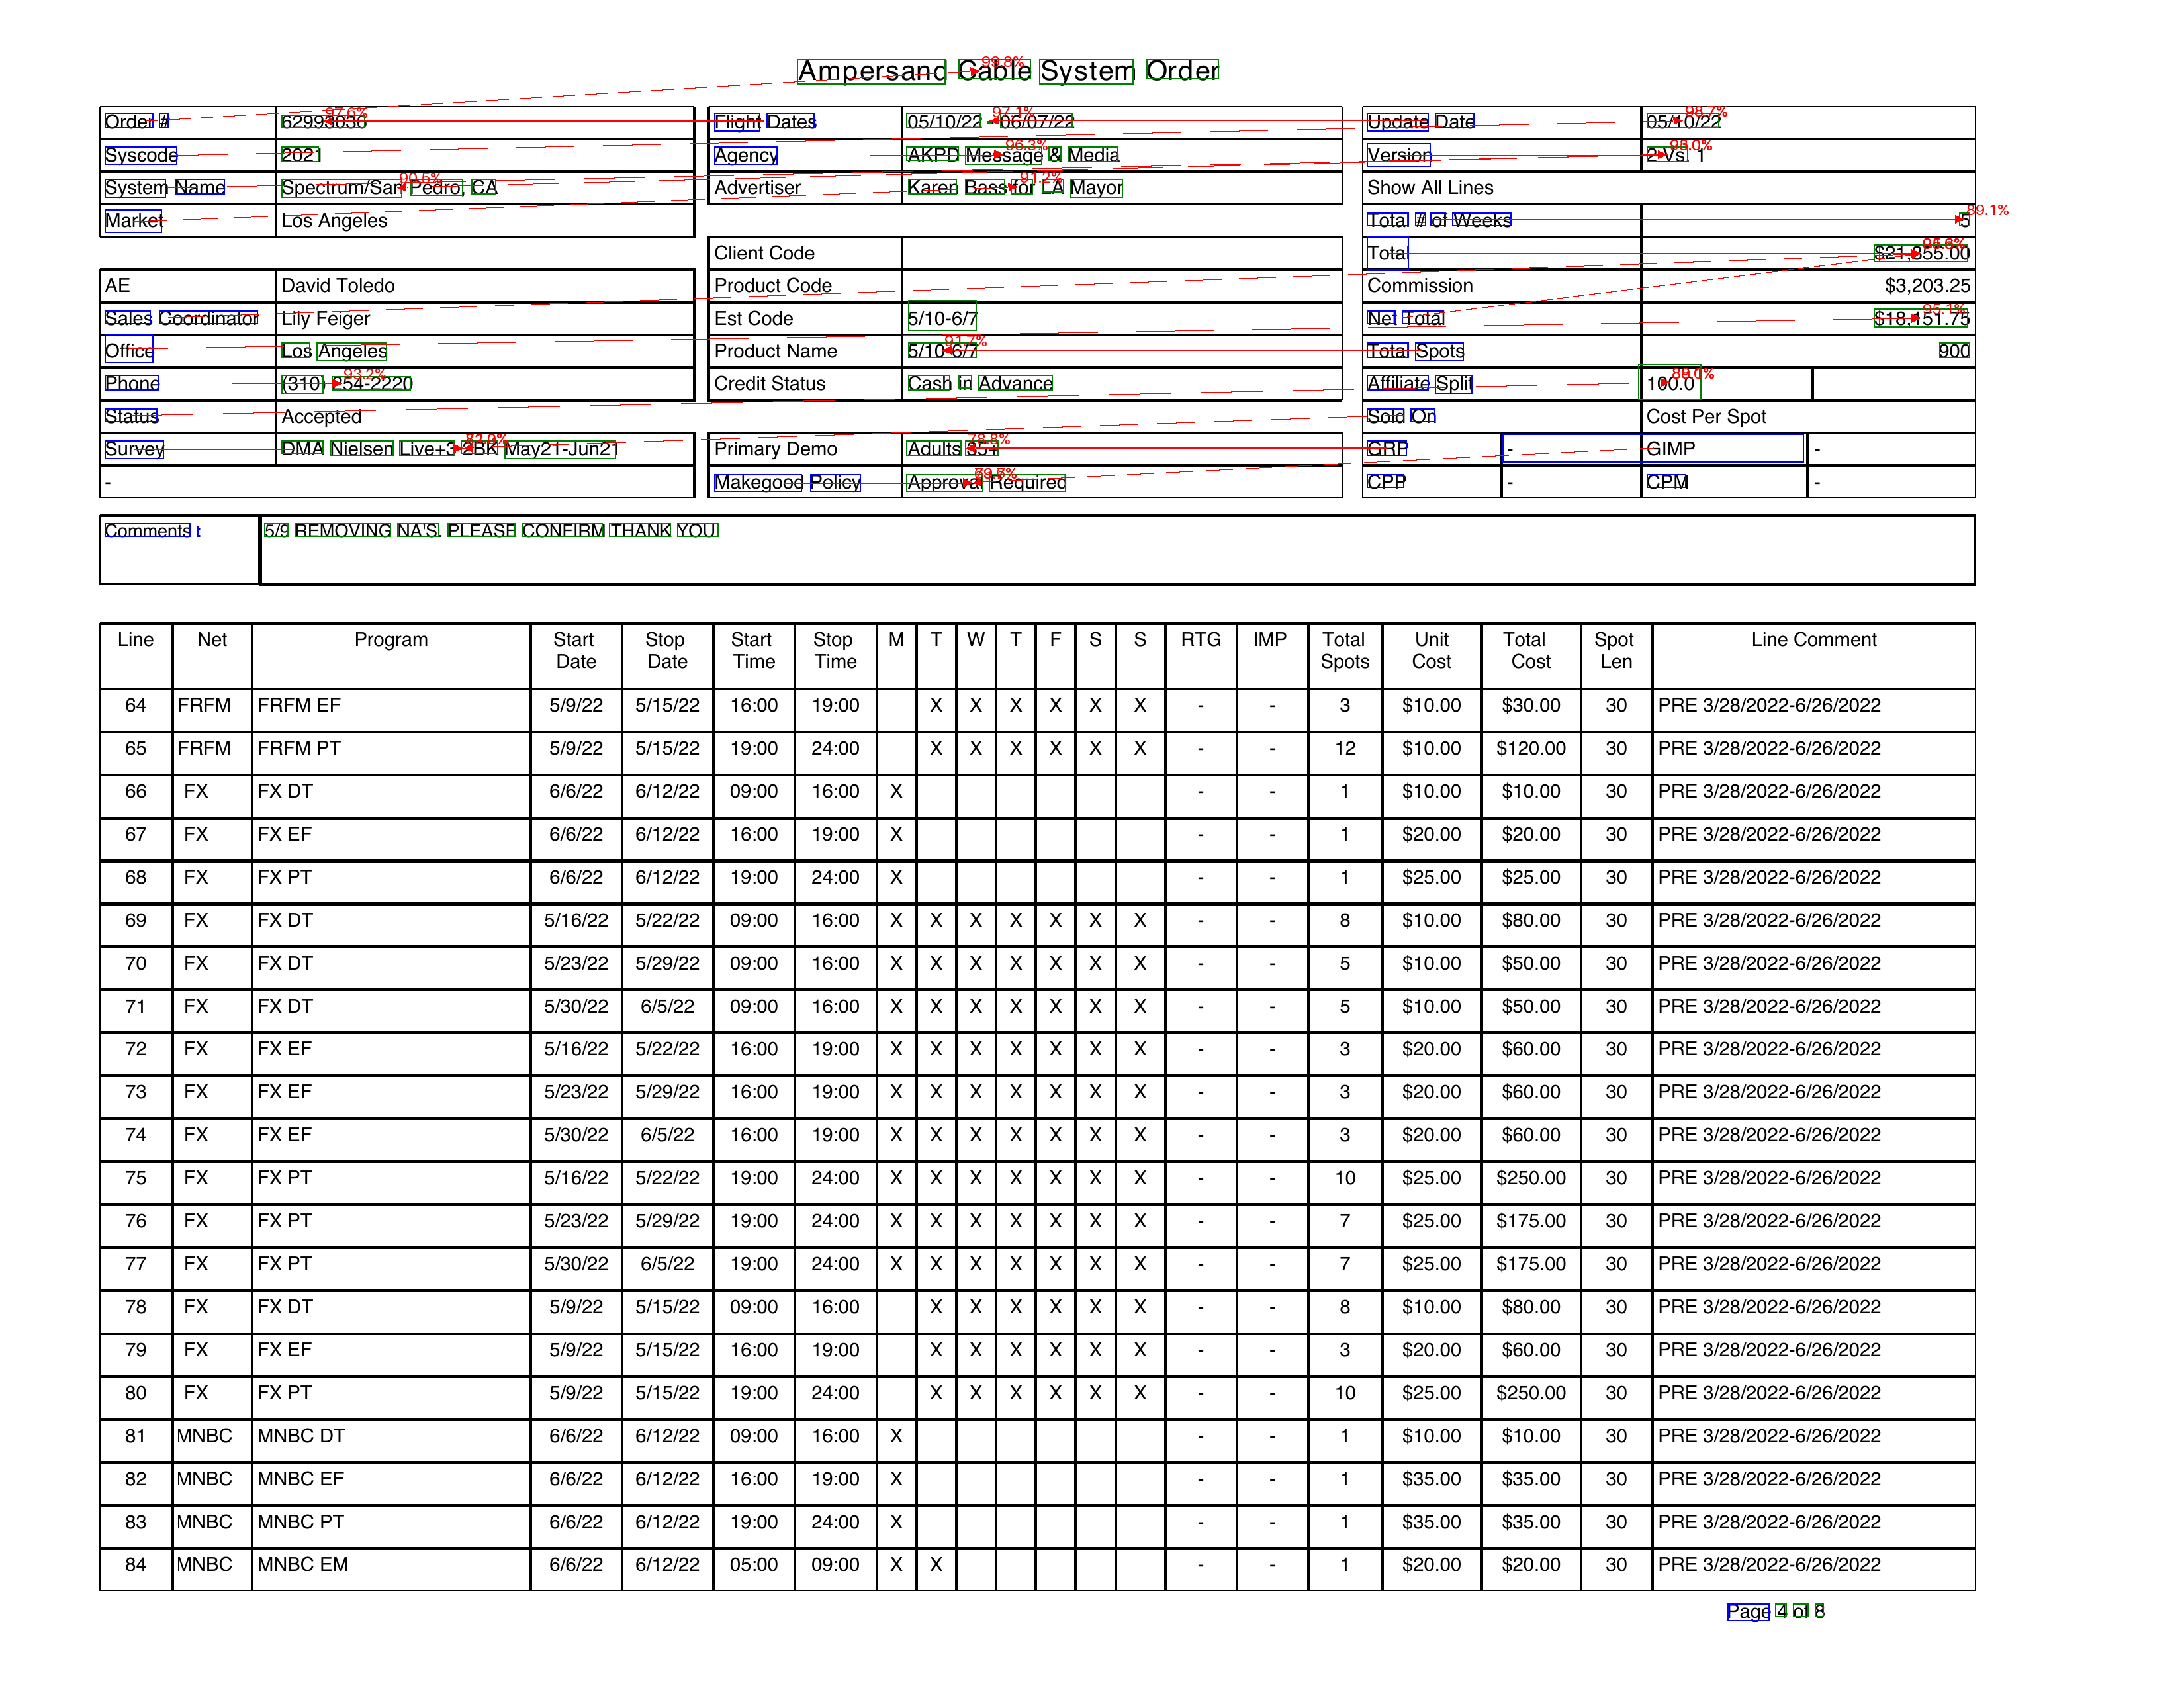

In [96]:
predict_relations(document_selected)
predict_relations_per_key(document_selected)